# Prediction of Financial Returns

### Introduction

In the xlsx file ’Financial returns.xlsx’, you will find daily returns of the BlackRock and
Hermes companies spanning from 2000 to 2024. In thisprojecte, we use AR and ARMA
models for predicting returns and time-varying variances. In particular, we develop a dynamic
portfolio management for investing in those two assets.

### Importing the librariries and the dataset

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics import tsaplots
from scipy import stats
import sys
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from scipy.stats import norm

path = "../data/Financial_returns.xlsx"
data = pd.read_excel(path)
data.head()

,Date,BLK returns,Hermes returns
0,2000-01-04,-4.511279,-6.118337
1,2000-01-05,-0.787432,-7.313495
2,2000-01-06,1.587306,-2.343765
3,2000-01-07,-0.781223,6.399958
4,2000-01-10,0.787375,3.383528


### Data Exploration

In [2]:
data.shape

(6235, 3)

In [3]:
data.describe()

,Date,BLK returns,Hermes returns
count,6235,6235.000000,6235.000000
mean,2012-01-09 15:52:13.472333568,0.091472,0.080779
min,2000-01-04 00:00:00,-15.524170,-11.757467
25%,2005-12-24 12:00:00,-0.833208,-0.809648
50%,2012-01-06 00:00:00,0.006815,0.037969
75%,2018-01-20 12:00:00,1.000922,0.967357
max,2024-01-31 00:00:00,19.560939,16.829634
std,NaN,2.116754,1.852676


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6235 entries, 0 to 6234
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            6235 non-null   datetime64[ns]
 1   BLK returns     6235 non-null   float64       
 2   Hermes returns  6235 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 146.3 KB


In [5]:
# Ensuring date is in right format

data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

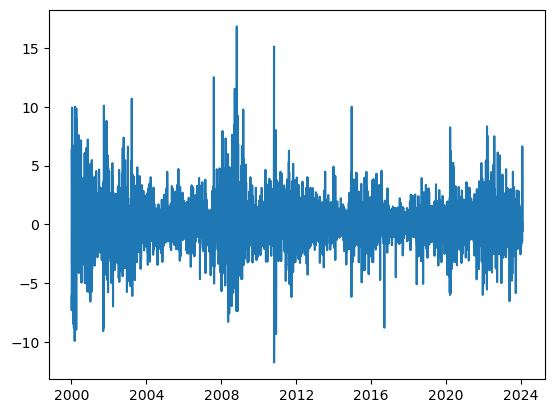

In [6]:
# PLotting to see if the series is stationary

plt.plot(data['Date'], data['Hermes returns'])
plt.show()

From a visual inspection, we see that the Hermes returns are stationary.

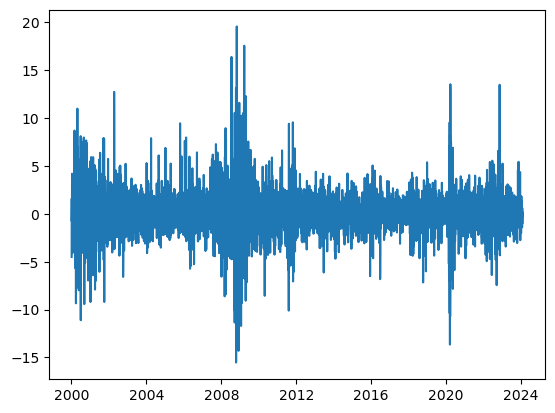

In [7]:
# PLotting to see if the series is stationary

plt.plot(data['Date'], data['BLK returns'])
plt.show()

We also see that BLK returns are stationary.

### Question 1 - HERMES RETURNS

**(a)** Compute the auto-correlogram up to 20 lags (see function tsaplots.plot_acf in Python)


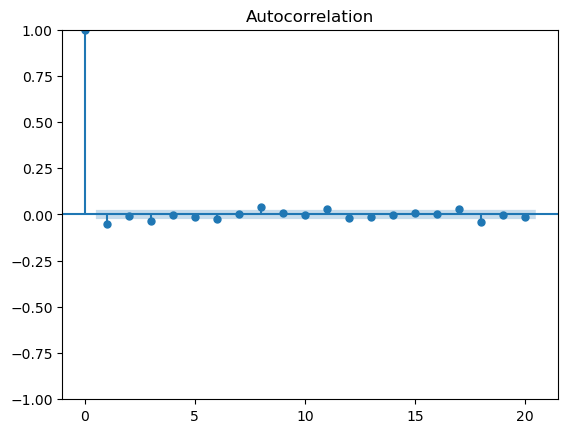

In [8]:
date = data[['Date']]
hermes_returns = data[['Hermes returns']]

# Displaying the autocorrelation plot for 20 lags
fig = tsaplots.plot_acf(hermes_returns, lags=20)
plt.show()

On this graph, we observe that lags are centered around 0 and fall within the blue shaded area which is the confidence interval that there is no autocorrelation. We observe the first lag is slighly outside the confidence bend so maybe there is some autocorrelation, but it doesn't look like that's the case. We expect to see such ACF on returns. 

**(b)** Perform a Box-Pierce test for the auto-correlation values from lag 1 to 50 included. With a 99% confidence level, do you reject the Null hypothesis of the test. What do you conclude?

In [9]:
autocorr = acf(hermes_returns, nlags = 50,fft=False) # here we compute auto-correlation for the first 50 auto-correlations
autocorr # printing autocorr values

array([ 1.00000000e+00, -5.28410869e-02, -7.99027507e-03, -3.33089409e-02,
       -1.77620528e-03, -1.29870344e-02, -2.50664425e-02,  2.83770121e-03,
        4.06341759e-02,  9.13175107e-03, -3.80363634e-03,  3.04611155e-02,
       -1.63882902e-02, -1.46618617e-02, -1.46095079e-03,  7.73586158e-03,
        4.79616082e-03,  2.70504055e-02, -4.03407006e-02, -2.01814727e-03,
       -1.37994557e-02,  1.01503116e-02, -1.67880564e-02, -1.34371538e-02,
       -6.41930446e-03, -1.48591344e-02, -1.08442714e-02, -1.14086129e-03,
        2.01832416e-02, -1.44611912e-02,  3.77153851e-02, -7.89542528e-03,
        2.08932673e-02, -3.08248843e-02,  4.89203999e-03, -4.80743641e-03,
       -5.92194629e-04,  1.51403347e-02, -1.39392977e-02,  9.99905351e-03,
       -1.14767405e-02,  1.79324791e-02, -1.72730325e-02,  1.01668289e-02,
       -2.10201462e-03,  7.76904267e-03, -2.94192178e-02, -2.48962966e-02,
       -1.25857571e-02,  1.32876807e-02, -1.88395712e-02])

In [10]:
# Let's do a Box-Pierce 

T = len(hermes_returns) # hermes returns sample size
test = T*np.sum(autocorr[1:51]**2) # BP test statistic
df = np.size(autocorr[1:51]) # 50 lags
threshold = stats.chi2.ppf(0.99,df) # 99% confidence interval
print('Test statistics: ' + str(round(test,2)))
print('Reject the Null hypothesis if above the following threshold: ' + str(round(threshold,2)))
Box_pierce = pd.DataFrame(np.reshape([test,threshold],[1,2]),columns=["BP test","critical value"])
print(Box_pierce)

Test statistics: 116.43
Reject the Null hypothesis if above the following threshold: 76.15
      BP test  critical value
0  116.425613       76.153891


From the Box-Pierce test for the auto-correlation values from lag 1 to 50 included, with a 99% confidence level, we reject the null hypothesis. We observe a test statistic of 116.43, which is greater than the threshhold 76.15.We reject the null hypothesis of no autocorrelation at a 99% confidence level. The rejection of the null hypothesis suggests that there is autocorrelation in the Hermes returns series at the lags up to 50. This indicates that past values have a statistically significant correlation with future values in the series, compared to null which claims no autocorrelation in the return series.

**(c)** Compute the partial auto-correlogram up to 20 lags (see function tsaplots.plot pacf
in Python) and choose an AR model to fit the series.

- i. What is the unconditional expectation of your estimated AR model ?
- ii. What is the unconditional variance of your estimated AR model ?

In [11]:
partial_autocorr = pacf(hermes_returns, nlags = 20) # here we compute auto-correlation for the first 50 auto-correlations
partial_autocorr

array([ 1.00000000e+00, -5.28495632e-02, -1.08161255e-02, -3.44237540e-02,
       -5.51299898e-03, -1.41446311e-02, -2.78980348e-02, -5.87205015e-04,
        3.94516227e-02,  1.16638225e-02, -2.11655908e-03,  3.26899043e-02,
       -1.27129665e-02, -1.46203864e-02,  1.18176994e-03,  6.98886327e-03,
        3.46085924e-03,  2.82469951e-02, -3.83803707e-02, -8.62924048e-03,
       -1.25888743e-02])

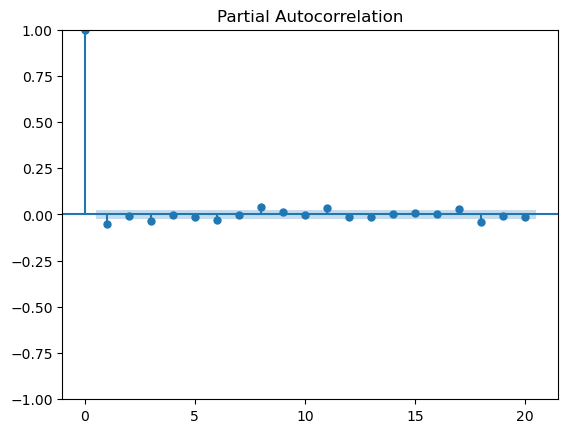

In [12]:
fig = tsaplots.plot_pacf(hermes_returns, lags=20)
plt.show()

Partial Autocorrelogram helps pick the p in AR(p) models, since we expect to see zeroes after the p lag. In the hermes returns PACF, it is difficult to make this choice as all lags are centered around zero. There is no clear cutoff. I will go with an AR(1) model as it is slighly outside the confidence bend.

                            AutoReg Model Results                             
Dep. Variable:         Hermes returns   No. Observations:                 6235
Model:                     AutoReg(1)   Log Likelihood              -12675.407
Method:               Conditional MLE   S.D. of innovations              1.848
Date:                Sun, 31 Mar 2024   AIC                          25356.814
Time:                        21:28:12   BIC                          25377.028
Sample:                             1   HQIC                         25363.820
                                 6235                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0860      0.023      3.672      0.000       0.040       0.132
Hermes returns.L1    -0.0528      0.013     -4.182      0.000      -0.078      -0.028
                        

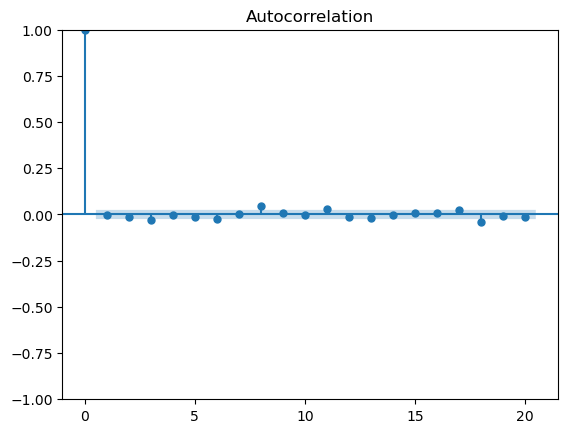

In [13]:
# Estimation of the AR(1) model

AR1_model = AutoReg(hermes_returns, lags=1).fit()
print(AR1_model.summary())

#  ACF of the residuals
residuals = AR1_model.resid
fig = tsaplots.plot_acf(residuals, lags=20)

We see no evidence of autocorrelation in the residuals

In [14]:
# Unconditional expectation of my AR model is 
unconditional_expectation = AR1_model.params.iloc[0]/(1-AR1_model.params.iloc[1])
print(f'Unconditional expectation of my AR(1) model is: {unconditional_expectation:.3f}')

Unconditional expectation of my AR(1) model is: 0.082


In [15]:
# Unconditional variance of my estimated AR(1) model is
residuals = AR1_model.resid
unconditional_variance = residuals.var(ddof=1) /(1-AR1_model.params.iloc[1]**2)
print(f'Unconditional variance of my AR(1) model is: {unconditional_variance:.3f}')

Unconditional variance of my AR(1) model is: 3.427


**(d)** Make a prediction of the next return using the AR model chosen in the previous
question.

We make prediction using the following equation: yt+1 = beta_0 + beta_1 * yt + et+1. I do not observe the shock at time t+1. It is on average equal to zero.My best guess is yt+1 = beta_0 + beta_1 * yt. This best guess corresponds to the conditional expectation of the model. yt is the latest return in the series. 

In [16]:
predicted_return = AR1_model.params.iloc[0] + (AR1_model.params.iloc[1]*data['Hermes returns'].iloc[-1])
print(f'Next predicted Hermes return is: {predicted_return:.3f}')

Next predicted Hermes return is: 0.115


**(e)** Assess the uncertainty of the prediction of the next return

Assuming that the error term is normally distributed and denoting by  yt the Hermes return at time t, the next return of an AR(p) model is a realization of the following Normal distribution:

- yT +1|yT , yT −1, . . . ∼ N(β0 + β1yT + . . . + βpyT −p+1, σ2)

In this model, the parameters {β0, β1, . . . , βp} are estimated by minimizing the sum of squared residuals using the OLS or the AutoReg packages, and σ2 is the variance of the error term. To estimate the variance of the error term, we compute the empirical variance of the residuals.
Using the estimate of σ2, build an interval such that we have a probability of 95% that our next return will fall within it, assuming that our Normality assumption holds.

In [17]:
AR1_residuals = AR1_model.resid
sigma_square = AR1_residuals.var(ddof=1)
print(f"Variance of residuals is: {sigma_square:.3f}")

Variance of residuals is: 3.417


In [18]:
# the interval is as follow: predicted_return +/- z * sq.root(variance)

z_critical = 1.96 # for normal distribution at 95% confidence interval

z_score = z_critical * np.sqrt(sigma_square)

lower_bound = predicted_return - z_score
upper_bound = predicted_return + z_score


print(f"z-critical is: {z_critical:.3f}")
print(f"z_score is: {z_score:.3f}")
print(f"Lower Bound is: {lower_bound:.3f}")
print(f"Upper Bound is: {upper_bound:.3f}")
print(f"Confidence interval such that we have a probability of 95% that our next return will fall within it, assuming Normality assumption holds is: [{lower_bound:.3f} , {upper_bound:.3f}]")

z-critical is: 1.960
z_score is: 3.623
Lower Bound is: -3.508
Upper Bound is: 3.738
Confidence interval such that we have a probability of 95% that our next return will fall within it, assuming Normality assumption holds is: [-3.508 , 3.738]


This is a very wide confidence interval and is explained by the large variance of the error term, reflecting high uncertainty.

**(f)** Bonus (optional). Returns are typically not normally distributed. Instead of
using a Normal distribution as we did in the previous question, build the same
interval but using a student distribution. To do so, estimate the degree of freedom
of the student distribution that fits best the standardized residuals of the estimated
AR model.

In [19]:
from scipy.stats import t

N = len(hermes_returns) # sample size
# Calculate the degrees of freedom
df = N - 2 # 2 is number of parameters

t_critical = t.ppf(0.975, df)


# Use the estimated degrees of freedom to calculate the t-score for the 95% confidence level
t_critical = t.ppf(0.975, df)

# Calculate the 95% prediction interval using the t distribution
t_score = t_critical * (sigma_square ** 0.5)

lower_bound = predicted_return - t_score
upper_bound = predicted_return + t_score

print(f"Degree of freedom is: {df:.3f}")
print(f"T-critical is: {t_critical:.3f}")
print(f"T_score is: {t_score:.3f}")
print(f"Lower Bound is: {lower_bound:.3f}")
print(f"Upper Bound is: {upper_bound:.3f}")
print(f"Confidence interval such that we have a probability of 95% that our next return will fall within it, assuming Normality assumption holds is: [{lower_bound:.3f} , {upper_bound:.3f}]")

Degree of freedom is: 6233.000
T-critical is: 1.960
T_score is: 3.624
Lower Bound is: -3.509
Upper Bound is: 3.739
Confidence interval such that we have a probability of 95% that our next return will fall within it, assuming Normality assumption holds is: [-3.509 , 3.739]


We notice that the interval is similar to the one from Normal Distribution due to large sample size. As the sample size increases, the Student's t distribution converges to the normal distribution. This is a consequence of the Central Limit Theorem. With a high degree of freedom, the t distribution's tails become less heavy, and its shape more closely resembles the bell curve of the normal distribution. Therefore, for large sample sizes, the t distribution and the normal distribution will give similar results for prediction intervals.

### Question 2 - Using returns from Hermes and BlackRock, find the minimum variance portfolio.
**(a)**  The portfolio that exhibits the smallest
variance is given by ω =
Σ−11
10Σ−11
in which 1 is a 2 by 1 vector filled with ones and Σ
stands for the covariance matrix of the asset returns. Compute this portfolio and
provide the proportion of wealth that should be invested in Hermes according to
it.

In [20]:
# Computing array with both returns

ret_all = data[["Hermes returns","BLK returns"]].to_numpy()
N = np.shape(ret_all)[0]
dimension = np.shape(ret_all)[1]

print('Shape of returns: ', N)
print('Dimension', dimension)

Shape of returns:  6235
Dimension 2


In [21]:
# Computing the mean and the covariance matrix

ret_mean = np.mean(ret_all,0)
cov_mat = np.cov(ret_all.transpose())

var_for_DF = np.zeros([2,2]) 
var_for_DF[:,0] = ret_mean
var_for_DF[:,1] = np.diag(cov_mat)
DF = pd.DataFrame(var_for_DF,columns=['Mean','Emp. Var.'],index=['Hermes','Blackrock'])

print(DF)
print()
print('Dimension of Covariance Matrix: ', cov_mat.shape)

               Mean  Emp. Var.
Hermes     0.080779   3.432410
Blackrock  0.091472   4.480649

Dimension of Covariance Matrix:  (2, 2)


In [22]:
inv_cov = np.linalg.inv(cov_mat) # inverse of the covariance matrix
vect_ones = np.ones([2]) # vector of ones

opt_port = np.matmul(inv_cov,vect_ones)/(np.matmul(vect_ones,np.matmul(inv_cov,vect_ones))) # optimal portfolio

print('Portfolio exhibiting the smallest variance among all possible portfolios: ' + str(opt_port))

Portfolio exhibiting the smallest variance among all possible portfolios: [0.58395254 0.41604746]


In [23]:
print('Weight to invest in Hermes: ' + f'{opt_port[0]:.3f}')
print('Weight to invest in Blackrock: ' + f'{opt_port[1]:.3f}')

Weight to invest in Hermes: 0.584
Weight to invest in Blackrock: 0.416


For the portfolio that exhibits the smallest variance, the proportion of wealth that should be invested in Hermes is approximately 58.40%. This means that 58.40% of the total investment should be allocated to Hermes to achieve the lowest possible portfolio variance. ​The rest, 41.6% should be invested in Blackrock. 

### Question 3 - Let us denote by yt the Hermes returns at time t.

**a)** We consider the demeaned series zt = yt - ȳ in which ȳ is estimated as ȳ = 1/T Σt=1^T yt (i.e., the average return).

Assuming that a return at time t is a realization from the random variable Yt exhibiting a constant expectation µ and a time-varying variance σ^2t. Show that (Yt - µ)^2 is an unbiased estimator of the variance σ^2t.

Every time we get a new sample, we get a new estimate. If my estimate is unbiased, on average, all estimates will be very close to the true coefficient if had an infinite amount of samples. So an estimate is said to be unbiased if its expected value is very close to the true parameter value.

E[(Yt - E(Yt))^2] = σ^2t </br>
Since E(Yt) = μ we simplify the formula: E[(Yt - μ)^2]. </br>
(Yt - μ)^2 represents the squared deviation of Yt from its mean. </br>

The variance itself is defined as the expected value of the squared deviations from the mean. This shows that (Yt - µ)^2 is indeed an unbiased estimator of the variance.

**b)** We consider the squared demeaned returns: {z^2t} from t=1 to T. According to the previous question, if the expectation is constant over time, the squared demeaned return stands for an estimate of the time-varying variance. Perform a Box-Pierce test for the autocorrelation values of the squared demeaned returns from lag 1 to 50 included. With a 99% confidence level, do you reject the Null hypothesis of the test. What do you conclude?

In [24]:
avg_hermes_returns = hermes_returns.mean()
zt = hermes_returns - avg_hermes_returns
zt_squared = zt** 2

autocorr = acf(zt_squared, nlags = 50,fft=False) # here we compute auto-correlation for the first 50 auto-correlations
print(autocorr) # printing autocorr 

[1.         0.25371677 0.17290657 0.14063168 0.11227725 0.1298584
 0.10939418 0.12493983 0.10967285 0.13015984 0.10631578 0.15880319
 0.12132527 0.11181121 0.09563384 0.0965897  0.13598398 0.07908337
 0.12198292 0.11280555 0.0824412  0.09665977 0.0854188  0.09032234
 0.07937956 0.08045275 0.08125859 0.17872429 0.10738065 0.09770579
 0.09403275 0.06310008 0.06668322 0.06063927 0.07110636 0.0785562
 0.06782967 0.09833119 0.09713726 0.09641747 0.10389199 0.08644204
 0.08692558 0.08598456 0.05009639 0.04246928 0.06748054 0.0644648
 0.05744659 0.04305022 0.0785318 ]


In [25]:
# Let's do a Box-Pierce 

T = len(zt_squared) # hermes returns sample size
test = T*np.sum(autocorr[1:51]**2) # BP test statistic
df = np.size(autocorr[1:51]) # 50 lags
threshold = stats.chi2.ppf(0.99,df) # 99% confidence interval
print('Test statistics: ' + str(round(test,2)))
print('Reject the Null hypothesis if above the following threshold: ' + str(round(threshold,2)))
Box_pierce = pd.DataFrame(np.reshape([test,threshold],[1,2]),columns=["BP test","critical value"])
print(Box_pierce)

Test statistics: 3500.06
Reject the Null hypothesis if above the following threshold: 76.15
       BP test  critical value
0  3500.060091       76.153891


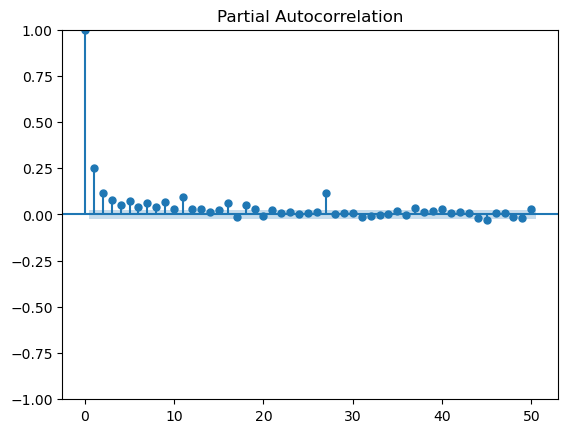

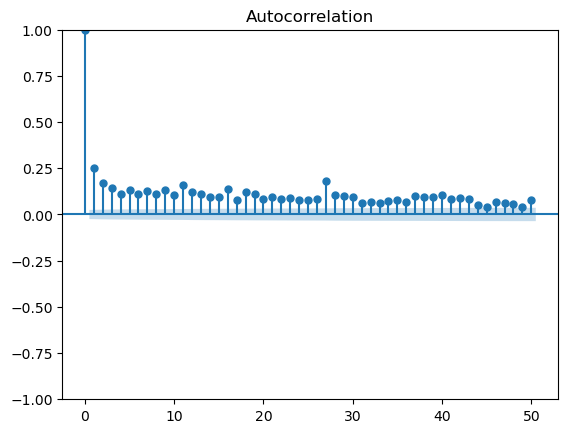

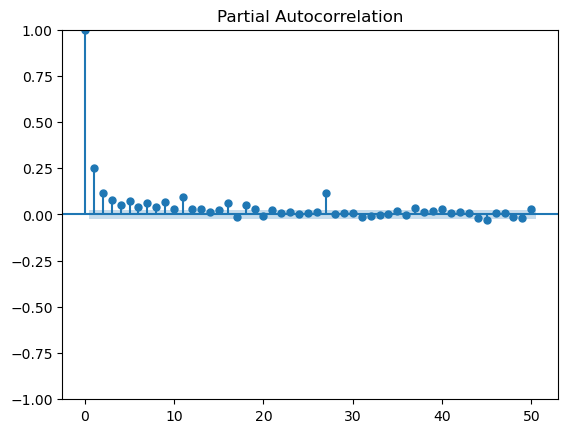

In [26]:
tsaplots.plot_acf(zt_squared, lags=50)
tsaplots.plot_pacf(zt_squared, lags=50)

From the Box-Pierce test for the auto-correlation values from lag 1 to 50 included, with a 99% confidence level, we reject the null hypothesis. We observe a very large test statistic of 3500, which is greater than the threshhold 76.15.We reject the null hypothesis of no autocorrelation at a 99% confidence level. The rejection of the null hypothesis suggests that there is autocorrelation in the squared demeaned Hermes returns series at the lags up to 50. This suggests that the variance of the returns is time-varying and not independent across time, which shows the presence of volatility in Hermes returns. </br>
This finding reinforces that financial returns have time-varying volatility, and when there is high volatility, future returns are expected to be highly volatile, or on the other hand, low volatility is followed by low volatility, which means series are autocorrelated.

**c)** Using the Bayesian Information Criterion (BIC), which model fits best the squared demeaned returns between an AR(9) model and an ARMA(1,1) model? 

In [27]:
## Estimating the AR(9) model
AR9_model = ARIMA(zt_squared, order=(9,0,0)).fit()

## Estimating the ARMA(1,1) model

ARMA_model = ARIMA(zt_squared, order=(1,0,1)).fit()

## Storing the value of the BIC for both models

BIC_AR9 = AR9_model.bic
BIC_ARMA = ARMA_model.bic

print(f"BIC for AR(9): {BIC_AR9:.3f}")
print(f"BIC for ARMA(1,1): {BIC_ARMA:.3f}")
print()

# Selecting the best model

if(BIC_AR9<BIC_ARMA):
    print('AR(9) is preferred according to BIC, compared to ARMA(1,1).')
else:
    print('ARMA(1,1) is preferred according to BIC, compared to AR(9).')

BIC for AR(9): 45401.234
BIC for ARMA(1,1): 45335.849

ARMA(1,1) is preferred according to BIC, compared to AR(9).


### Question 4 - Find the minimum variance portfolio with time-varying variance.

**(a)** Using the squared demeaned returns of Hermes and an ARMA(1,1) model, predict the next squared demeaned return of the series, denoted by ˆσ^2T+1,HM. What is your prediction?

In [28]:
ARMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Hermes returns   No. Observations:                 6235
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -22650.449
Date:                Sun, 31 Mar 2024   AIC                          45308.898
Time:                        21:28:22   BIC                          45335.849
Sample:                             0   HQIC                         45318.239
                               - 6235                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5419      0.809      4.378      0.000       1.956       5.128
ar.L1          0.9762      0.002    441.387      0.000       0.972       0.981
ma.L1         -0.8998      0.003   -282.841      0.000      -0.906      -0.894
sigma2        83.7294      0.203    412.582      0.000      83.332      84.127
===================================================================================
Ljung-Box (L1) (Q):                  66.67   Jarque-Bera (JB):          12765359.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            10.82
Prob(H) (two-sided):                  0.00   Kurtosis:                       223.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
hermes_returns = data['Hermes returns']
avg_hermes_returns = hermes_returns.mean()
zt_hermes = hermes_returns - avg_hermes_returns
zt_hermes_squared = zt_hermes** 2

T = len(zt_hermes_squared)

next_sq_hermes_return= ARMA_model.predict(start=T,end=T+1).reset_index(drop=True)[0]

print(f"The next squared demeaned return of the Hermes returns is: {next_sq_hermes_return:.3f}")
print(f"The next level demeaned return of the Hermes returns is: {np.sqrt(next_sq_hermes_return):.3f}")

The next squared demeaned return of the Hermes returns is: 3.781
The next level demeaned return of the Hermes returns is: 1.944


In [30]:
# another way of doing this directly using the equation

sigma2_T_hermes = zt_hermes_squared.iloc[-1] # previous value 
avg_squared_hermes_returns = zt_hermes_squared.mean() # average
AR_param_hermes = ARMA_model.params.iloc[1]  # AR(1) coefficient
MA_param_hermes = ARMA_model.params.iloc[2]  # MA(1) coefficient
residuals_T_hermes = ARMA_model.resid.iloc[-1] # error term at time t

next_sq_hermes_return = avg_squared_hermes_returns + AR_param_hermes * (sigma2_T_hermes- avg_squared_hermes_returns) + MA_param_hermes * residuals_T_hermes

print(f"The next squared demeaned return of the Hermes returns is: {next_sq_hermes_return:.3f}")
print(f"The next level demeaned return of the Hermes returns is: {np.sqrt(next_sq_hermes_return):.3f}")

The next squared demeaned return of the Hermes returns is: 3.778
The next level demeaned return of the Hermes returns is: 1.944


**(b)** Using the squared demeaned returns of BlackRock and an ARMA(1,1) model, predict the next squared demeaned return of the series, denoted by ˆσ^2T+1,BLK. What is your prediction?

In [31]:
blackrock_returns = data['BLK returns']
avg_blackrock_returns = blackrock_returns.mean()
zt_blk = blackrock_returns - avg_blackrock_returns
zt_blk_squared = zt_blk** 2

ARMA_blk_model = ARIMA(zt_blk_squared, order=(1,0,1)).fit()
ARMA_blk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            BLK returns   No. Observations:                 6235
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -24906.193
Date:                Sun, 31 Mar 2024   AIC                          49820.386
Time:                        21:28:23   BIC                          49847.338
Sample:                             0   HQIC                         49829.728
                               - 6235                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4715      1.446      3.092      0.002       1.637       7.306
ar.L1          0.9768      0.002    590.645      0.000       0.974       0.980
ma.L1         -0.8806      0.003   -286.544      0.000      -0.887      -0.875
sigma2       172.6383      0.536    322.358      0.000     171.589     173.688
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):           7292500.09
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             9.66
Prob(H) (two-sided):                  0.00   Kurtosis:                       169.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
T = len(zt_blk_squared)

next_sq_blk_return = ARMA_blk_model.predict(start=T,end=T+1).reset_index(drop=True)[0]

print(f"The next squared demeaned return of the BLK returns is: {next_sq_blk_return:.3f}")
print(f"The next level demeaned return of the BLK returns is: {np.sqrt(next_sq_blk_return):.3f}")

The next squared demeaned return of the BLK returns is: 1.520
The next level demeaned return of the BLK returns is: 1.233


In [33]:
# another way of doing this directly from the equation

sigma2_T_blk = zt_blk_squared.iloc[-1] # previous value 
avg_squared_blk_returns = zt_blk_squared.mean() # average
AR_param_blk = ARMA_blk_model.params.iloc[1]  # AR(1) coefficient
MA_param_blk = ARMA_blk_model.params.iloc[2]  # MA(1) coefficient
residuals_T_blk = ARMA_blk_model.resid.iloc[-1] # error term at time t


next_sq_blk_return = avg_squared_blk_returns + AR_param_blk * (sigma2_T_blk- avg_squared_blk_returns) + MA_param_blk * residuals_T_blk

print(f"The next squared demeaned return of the BLK returns is: {next_sq_blk_return:.3f}")
print(f"The next level demeaned return of the BLK returns is: {np.sqrt(next_sq_blk_return):.3f}")

The next squared demeaned return of the BLK returns is: 1.520
The next level demeaned return of the BLK returns is: 1.233


**(c)** Assuming a constant correlation, build the covariance matrix at time T + 1 as follows:

Σ^T +1=</br> 
[σ^2T+1,BLK  ρ^σ^T+1,BLKσ^T+1, </br>HM]
[ρ^σ^T+1,BLKσ^T+1,HM  σ^2T+1,HM]

in which ˆρ stands for an estimate of the correlation coefficient between BlackRock and Hermes returns. Compute the minimum variance portfolio using your predicted time-varying covariance matrix Σ^T+1 and provide the proportion of wealth that should be invested in Hermes according to it.


In [34]:
correlation_coef = data['Hermes returns'].corr(data['BLK returns']) # calculating correlation coefficient between the two returns 

print(f"Correlation coefficient between Hermes and Blackrock is: {correlation_coef:.3f}")
print(f"The next squared demeaned return of the Hermes returns is: {next_sq_hermes_return:.3f}")
print(f"The next squared demeaned return of the BLK returns is: {next_sq_blk_return:.3f}")

Correlation coefficient between Hermes and Blackrock is: 0.213
The next squared demeaned return of the Hermes returns is: 3.778
The next squared demeaned return of the BLK returns is: 1.520


In [35]:

# Calculating the covariance between Hermes and Blackrock  using the predicted variances and correlation coefficient 
cov_T_plus_1 = correlation_coef * np.sqrt(next_sq_hermes_return) * np.sqrt(next_sq_blk_return) # covariance(x,y) = corr(x,y) * sqrt(var(x) * var(y))

# Predicted covariance matrix Σ^T+1
cov_mat = np.array([[next_sq_blk_return, cov_T_plus_1],
                              [cov_T_plus_1, next_sq_hermes_return]])

# Calculating the inverse of the covariance matrix
inv_cov = np.linalg.inv(cov_mat)

# Creating  a vector of ones

vect_ones = np.ones(2)

# Optimal portfolio

opt_port = np.matmul(inv_cov,vect_ones)/(np.matmul(vect_ones,np.matmul(inv_cov,vect_ones))) # optimal portfolio

print('Portfolio exhibiting the smallest variance among all possible portfolios: ' + str(opt_port))
print('Weight to invest in Blackrock: ' + f'{opt_port[0]:.3f}')
print('Weight to invest in Hermes: ' + f'{opt_port[1]:.3f}')
print()
print('Covariance matrix:')
print(cov_mat)

Portfolio exhibiting the smallest variance among all possible portfolios: [0.76394152 0.23605848]
Weight to invest in Blackrock: 0.764
Weight to invest in Hermes: 0.236

Covariance matrix:
[[1.52013836 0.51028852]
 [0.51028852 3.7784034 ]]


For the portfolio that exhibits the smallest variance, the proportion of wealth that should be invested in Hermes at time t+1 is approximately 23%, compared to Blackrock that is approximately 77%.

Since returns have time-varying variance, AR models don't really make sense. That's why we did all the analysis on squared demeaned returns.